# Capstone Project: Battle of Neighborhoods
## Applied Data Science Capstone by IBM/Coursera

### Table of Contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find a shortlist of nieghbourhooods in and around Dayton (Ohio, USA) that are preferrable for opening a Brewery. 

The idea is to find nieghborhoods around population centers, particularly ones with a large population above 18 years of age, and high income brackets, to ensure a large clientele. 
The brewery would fare even better well if there isn't too much competition from other breweries in the immediate vicinity.

We will use data science powers to cluster and select a cluster with a few most promissing neighborhoods guided by the above criteria. Advantages of these neighbourhoods will then be expressed so that best possible final location can be chosen by stakeholders.


## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of people in the neighbourhoods
* number of people in the negihbourhoods above a certain age (18 years)
* markers of spending ability through per capita income and median housing value
* venues in the neighborhood that increase the appeal of the neighborhoods and in turn the likelihood, of customers, to visit the brewery
* number of and distance to bars/breweries in the neighborhood, if any


For each city in the counties surrounding and containing the greater Dayton matropolitan area.

Following data sources will be needed to extract/generate the required information:
* the name of neighbourhood in the 4 counties surrounding Dayton (Montgomery, Miami, Clark, and Greene) will be obtianed from the pgeocode package in python (! pip install pgeocode)
* the US census data will be accessed via its api for demographic information in these neighborhoods (https://api.census.gov/data/)
* number of venues and their type and location in every neighborhood will be obtained using **Foursquare API**


## Methodology <a name="methodology"></a>

### Import necessary packages databases

In [1]:
import requests

import pgeocode
import numpy as np
import pandas as pd
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
# import k-means from clustering stage
from sklearn.cluster import KMeans
#! conda install -c districtdatalabs yellowbrick --yes
from yellowbrick.cluster import KElbowVisualizer

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import json

/home/dnaragani/anaconda3/envs/spyder/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [11]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
#put your census API key here
apiKey = "" # census

### DataSet 1: obtain a list of zipcodes relevant to Ohio and sub-select those in the counties surrounding Dayton, Ohio

In [3]:
nomi = pgeocode.Nominatim('us')
zipcodes = [str(i) for i in np.arange(43001,46000)]
a = nomi.query_postal_code(zipcodes)
a = a[a['state_name']=='Ohio']
a = a[['postal_code','place_name','county_name','latitude','longitude']]

In [4]:
df = a[a.county_name.str.contains('Clark',case=False) | a.county_name.str.contains('Miami',case=False) | a.county_name.str.contains('Greene',case=False) | a.county_name.str.contains('Montgomery',case=False)]
df.head()
# df['postal_code'].drop_duplicates()

,postal_code,place_name,county_name,latitude,longitude
9,43010,Catawba,Clark,39.9991,-83.6222
2300,45301,Alpha,Greene,39.7117,-84.0233
2304,45305,Bellbrook,Greene,39.6402,-84.0824
2306,45307,Bowersville,Greene,39.5806,-83.7249
2307,45308,Bradford,Miami,40.1286,-84.4293


### DataSet 2: obtain the total population, population above 18 years, estiamted income/per capita income, and median house values from U.S. census database 

In [5]:
OHZips=list(df['postal_code'])
OHZips = ','.join(OHZips)

#construct the API call we will use
baseAPI = "https://api.census.gov/data/2018/acs/acs5?key=%s&get=B01003_001E&for=zip%%20code%%20tabulation%%20area:%s" 
calledAPI = baseAPI % (apiKey, OHZips)

# B15001_002E -- total male above 18
# B15001_043E -- total female above 18
# B19001_001E -- estime income past 12 months
# B25077_001E -- median housing value
#call the API and collect the response
response = requests.get(calledAPI)

#load the response into a JSON, ignoring the first element which is just field labels
formattedResponse = json.loads(response.text)[1:]

#flip the order of the response from [population, zipcode] -> [zipcode, population]
formattedResponse = [item[::-1] for item in formattedResponse]

#store the response in a dataframe
OHZipPopulations = pd.DataFrame(columns=['zipcode', 'population'], data=formattedResponse)
OHZipPopulations.head()

,zipcode,population
0,43010,260
1,45384,2053
2,45319,378
3,45361,328
4,45372,319


In [6]:
OHZips=list(df['postal_code'])
OHZips = ','.join(OHZips)

# B15001_002E -- total male above 18
# B15001_043E -- total female above 18
# B19001_001E -- estime income past 12 months
# B19301_001E -- per capita income
# B25077_001E -- median housing value
#call the API and collect the response

#construct the API call we will use
baseAPI = "https://api.census.gov/data/2018/acs/acs5?key=%s&get=B15001_002E&for=zip%%20code%%20tabulation%%20area:%s" 
calledAPI = baseAPI % (apiKey, OHZips)


response = requests.get(calledAPI)

#load the response into a JSON, ignoring the first element which is just field labels
formattedResponse = json.loads(response.text)[1:]

#flip the order of the response from [population, zipcode] -> [zipcode, population]
formattedResponse = [item[::-1] for item in formattedResponse]

#store the response in a dataframe
OHZip_Male = pd.DataFrame(columns=['zipcode', 'Male_above_18'], data=formattedResponse)
OH_census = OHZipPopulations.join(OHZip_Male.set_index('zipcode'), on='zipcode')

#construct the API call we will use
baseAPI = "https://api.census.gov/data/2018/acs/acs5?key=%s&get=B15001_043E&for=zip%%20code%%20tabulation%%20area:%s" 
calledAPI = baseAPI % (apiKey, OHZips)

response = requests.get(calledAPI)

#load the response into a JSON, ignoring the first element which is just field labels
formattedResponse = json.loads(response.text)[1:]

#flip the order of the response from [population, zipcode] -> [zipcode, population]
formattedResponse = [item[::-1] for item in formattedResponse]

#store the response in a dataframe
OHZipFemale = pd.DataFrame(columns=['zipcode', 'Female_above_18'], data=formattedResponse)
OH_census = OH_census.join(OHZipFemale.set_index('zipcode'), on='zipcode')

#construct the API call we will use
baseAPI = "https://api.census.gov/data/2018/acs/acs5?key=%s&get=B19301_001E&for=zip%%20code%%20tabulation%%20area:%s" 
calledAPI = baseAPI % (apiKey, OHZips)

response = requests.get(calledAPI)

#load the response into a JSON, ignoring the first element which is just field labels
formattedResponse = json.loads(response.text)[1:]

#flip the order of the response from [population, zipcode] -> [zipcode, population]
formattedResponse = [item[::-1] for item in formattedResponse]

#store the response in a dataframe
OHZipIncome = pd.DataFrame(columns=['zipcode', 'Income'], data=formattedResponse)
OH_census = OH_census.join(OHZipIncome.set_index('zipcode'), on='zipcode')

#construct the API call we will use
baseAPI = "https://api.census.gov/data/2018/acs/acs5?key=%s&get=B25077_001E&for=zip%%20code%%20tabulation%%20area:%s" 
calledAPI = baseAPI % (apiKey, OHZips)

response = requests.get(calledAPI)

#load the response into a JSON, ignoring the first element which is just field labels
formattedResponse = json.loads(response.text)[1:]

#flip the order of the response from [population, zipcode] -> [zipcode, population]
formattedResponse = [item[::-1] for item in formattedResponse]

#store the response in a dataframe
OHZipPropertyCost = pd.DataFrame(columns=['zipcode', 'PropertyCost'], data=formattedResponse)
OH_census = OH_census.join(OHZipPropertyCost.set_index('zipcode'), on='zipcode')

OH_census.head()

,zipcode,population,Male_above_18,Female_above_18,Income,PropertyCost
0,43010,260,100,90,23990,105200
1,45384,2053,894,1014,7159,115700
2,45319,378,141,149,27630,125000
3,45361,328,142,114,20548,102300
4,45372,319,122,132,25755,88200


In [7]:
OH_census = OH_census[OH_census['PropertyCost'].astype(int) != -666666666]


### Merge the location and demographics datasets

In [8]:
df = df.join(OH_census.set_index('zipcode'), on='postal_code')
df.dropna(inplace=True)
print(df.shape)
df.tail()

(71, 10)


,postal_code,place_name,county_name,latitude,longitude,population,Male_above_18,Female_above_18,Income,PropertyCost
2501,45502,Springfield,Clark,39.9242,-83.8088,15779,6205,6420,33828,164800
2502,45503,Springfield,Clark,39.9528,-83.7804,32363,11871,13617,26647,114000
2503,45504,Springfield,Clark,39.9408,-83.8343,17639,6675,7337,27799,118900
2504,45505,Springfield,Clark,39.9106,-83.7856,19919,7079,8072,19355,71900
2505,45506,Springfield,Clark,39.9104,-83.8275,13868,4626,5375,20055,70600


### DataSet 3: obtain venues around the centers of the neighborhoods from FourSquare API

In [12]:
LIMIT = 100
radius = 2000
def getNearbyVenues(names, latitudes, longitudes, radius=3200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
Dayton_venues = getNearbyVenues(names=df['postal_code'],
                                   latitudes=df['latitude'],
                                   longitudes=df['longitude']
                                  )
Dayton_venues.head()

43010
45305
45307
45308
45309
45312
45314
45315
45316
45317
45318
45319
45322
45323
45324
45325
45326
45327
45335
45337
45339
45341
45342
45344
45345
45349
45354
45356
45359
45361
45368
45369
45370
45371
45372
45373
45377
45383
45384
45385
45387
45402
45403
45404
45405
45406
45409
45410
45414
45415
45416
45417
45419
45420
45424
45426
45429
45430
45431
45432
45434
45439
45440
45449
45458
45459
45502
45503
45504
45505
45506


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,43010,39.9991,-83.6222,Yuengling Acres,39.986082,-83.590175,Pub
1,45305,39.6402,-84.0824,Dot’s Market,39.636726,-84.074804,Grocery Store
2,45305,39.6402,-84.0824,The Blueberry Cafe,39.636843,-84.073397,Breakfast Spot
3,45305,39.6402,-84.0824,Dairy Shed,39.636514,-84.072941,Ice Cream Shop
4,45305,39.6402,-84.0824,Skyline Chili,39.637476,-84.106346,Hot Dog Joint


### Group the venue data according to the respective neghborhood and use get_dummies to convert categories to features

In [14]:
Dayton_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
43010,1,1,1,1,1,1
45305,70,70,70,70,70,70
45307,3,3,3,3,3,3
45308,5,5,5,5,5,5
45309,21,21,21,21,21,21
...,...,...,...,...,...,...
45502,99,99,99,99,99,99
45503,36,36,36,36,36,36
45504,100,100,100,100,100,100


In [15]:
print('There are {} uniques categories.'.format(len(Dayton_venues['Venue Category'].unique())))

There are 257 uniques categories.


In [16]:
# one hot encoding
dayton_onehot = pd.get_dummies(Dayton_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dayton_onehot['Neighborhood'] = Dayton_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dayton_onehot.columns[-1]] + list(dayton_onehot.columns[:-1])
dayton_onehot = dayton_onehot[fixed_columns]

dayton_grouped = dayton_onehot.groupby('Neighborhood').mean().reset_index()
dayton_grouped

,Neighborhood,Yoga Studio,ATM,Accessories Store,Airport,Airport Service,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,43010,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,45305,0.0,0.000000,0.0,0.0,0.0,0.028571,0.0,0.00,0.0,...,0.0,0.014286,0.014286,0.0,0.0,0.0,0.0,0.0,0.014286,0.000000
2,45307,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,45308,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,45309,0.0,0.000000,0.0,0.0,0.0,0.095238,0.0,0.00,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,45502,0.0,0.010101,0.0,0.0,0.0,0.030303,0.0,0.00,0.0,...,0.0,0.000000,0.010101,0.0,0.0,0.0,0.0,0.0,0.000000,0.010101
66,45503,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,...,0.0,0.000000,0.027778,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
67,45504,0.0,0.010000,0.0,0.0,0.0,0.050000,0.0,0.01,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.020000,0.010000
68,45505,0.0,0.000000,0.0,0.0,0.0,0.022989,0.0,0.00,0.0,...,0.0,0.000000,0.011494,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


### Short-list the top 10 most common veneus in each neighborhood to describe the neighborhood to the customer

In [17]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = dayton_grouped['Neighborhood']

for ind in np.arange(dayton_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dayton_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,43010,Pub,Hot Dog Joint,Food Truck,Food Stand,Food & Drink Shop,Food,Fondue Restaurant,Flower Shop,Flea Market,Fish & Chips Shop
1,45305,Bank,Sandwich Place,Grocery Store,Pizza Place,Discount Store,American Restaurant,Fast Food Restaurant,Hardware Store,Supermarket,Mexican Restaurant
2,45307,Trail,Farm,Rest Area,Women's Store,Flea Market,Fabric Shop,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop
3,45308,Grocery Store,Gas Station,Discount Store,Construction & Landscaping,Pizza Place,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
4,45309,Gas Station,Discount Store,Sandwich Place,American Restaurant,Fast Food Restaurant,Fried Chicken Joint,Pizza Place,Bank,Theater,Grocery Store


### Merge all the 3 datasets into a single Pandas dataframe

In [18]:
dayton_grouped = OH_census.join(dayton_grouped.set_index('Neighborhood'), on='zipcode')
dayton_grouped

,zipcode,population,Male_above_18,Female_above_18,Income,PropertyCost,Yoga Studio,ATM,Accessories Store,Airport,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,43010,260,100,90,23990,105200,0.0,0.000000,0.0,0.00,...,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.00,0.00
1,45384,2053,894,1014,7159,115700,0.0,0.000000,0.0,0.00,...,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.00,0.00
2,45319,378,141,149,27630,125000,0.0,0.000000,0.0,0.00,...,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.00,0.00
3,45361,328,142,114,20548,102300,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,45372,319,122,132,25755,88200,0.0,0.000000,0.0,0.25,...,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,45504,17639,6675,7337,27799,118900,0.0,0.010000,0.0,0.00,...,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.02,0.01
70,45309,12439,4630,5150,32710,147700,0.0,0.000000,0.0,0.00,...,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.00,0.00
71,45369,3492,1336,1389,30400,157400,0.0,0.000000,0.0,0.00,...,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.00,0.00
72,45373,35989,13144,14119,31306,150600,0.0,0.047619,0.0,0.00,...,0.0,0.0,0.031746,0.00,0.0,0.0,0.0,0.0,0.00,0.00


### Drop the zipcode identifier for the neighborhood and cluster the neighbourhoods using KMeans

/home/dnaragani/anaconda3/envs/spyder/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dnaragani/anaconda3/envs/spyder/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/dnaragani/anaconda3/envs/spyder/lib/python3.8/site-packages/scipy/signal/_peak_finding.py:77: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
/home/dnaragani/anaconda3/envs/spyder/lib/python3.8/site-packages/scipy/signal/_peak_finding.py:78: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)
/home/dnaragani/anaconda3/envs/spyder/lib/python3.8/site-packages/scipy/signal/_peak_finding.py:77: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, plus)
/home/dnaragani/anaconda3/en

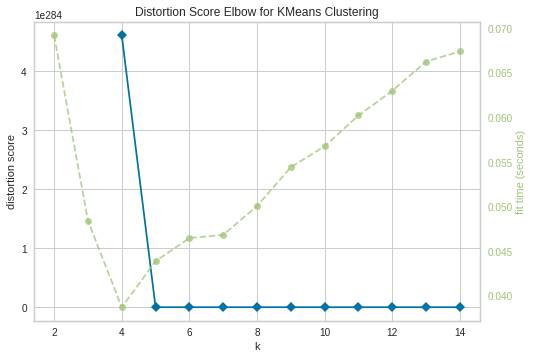

In [19]:
model = KMeans()
visualizer = KElbowVisualizer(model,k=(2,15))

dayton_grouped.dropna(inplace=True)
dayton_grouped_clustering = dayton_grouped.drop('zipcode', 1)

visualizer.fit(dayton_grouped_clustering)
visualizer.show()

In [20]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dayton_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 4, 2, 4, 4, 3, 4, 3, 1], dtype=int32)

In [ ]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [46]:
dayton_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
dayton_merged = dayton_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='postal_code')
dayton_merged.set_index('Cluster Labels', inplace=True)
dayton_merged # check the last columns!

,postal_code,place_name,county_name,latitude,longitude,population,Male_above_18,Female_above_18,Income,PropertyCost,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,,,,,,,
4.0,43010,Catawba,Clark,39.9991,-83.6222,260,100,90,23990,105200,Pub,Hot Dog Joint,Food Truck,Food Stand,Food & Drink Shop,Food,Fondue Restaurant,Flower Shop,Flea Market,Fish & Chips Shop
4.0,45305,Bellbrook,Greene,39.6402,-84.0824,11161,4134,4253,43994,207600,Bank,Sandwich Place,Grocery Store,Pizza Place,Discount Store,American Restaurant,Fast Food Restaurant,Hardware Store,Supermarket,Mexican Restaurant
4.0,45307,Bowersville,Greene,39.5806,-83.7249,330,119,124,18409,78800,Trail,Farm,Rest Area,Women's Store,Flea Market,Fabric Shop,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop
2.0,45308,Bradford,Miami,40.1286,-84.4293,4139,1620,1585,26801,106900,Grocery Store,Gas Station,Discount Store,Construction & Landscaping,Pizza Place,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
4.0,45309,Brookville,Montgomery,39.8414,-84.4165,12439,4630,5150,32710,147700,Gas Station,Discount Store,Sandwich Place,American Restaurant,Fast Food Restaurant,Fried Chicken Joint,Pizza Place,Bank,Theater,Grocery Store
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.0,45502,Springfield,Clark,39.9242,-83.8088,15779,6205,6420,33828,164800,Fast Food Restaurant,Pizza Place,Discount Store,Sandwich Place,Coffee Shop,Fried Chicken Joint,Bank,Chinese Restaurant,American Restaurant,Supermarket
3.0,45503,Springfield,Clark,39.9528,-83.7804,32363,11871,13617,26647,114000,Pizza Place,Fast Food Restaurant,Coffee Shop,Mexican Restaurant,Pharmacy,Bank,Gas Station,Supermarket,Taco Place,Bar
3.0,45504,Springfield,Clark,39.9408,-83.8343,17639,6675,7337,27799,118900,Sandwich Place,Pizza Place,American Restaurant,Discount Store,Coffee Shop,Fast Food Restaurant,Gas Station,Clothing Store,Mobile Phone Shop,Wings Joint


## Results <a name="results"></a>

In [47]:
# create map
dayton_merged.reset_index(inplace=True)
dayton_merged.dropna(inplace=True)
map_clusters = folium.Map(location=[dayton_merged['latitude'].mean(), dayton_merged['longitude'].mean()], zoom_start=12)
#tiles='Stamen Toner',
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dayton_merged['latitude'], dayton_merged['longitude'], dayton_merged['place_name'], dayton_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Estimate cluster labels depending on venues

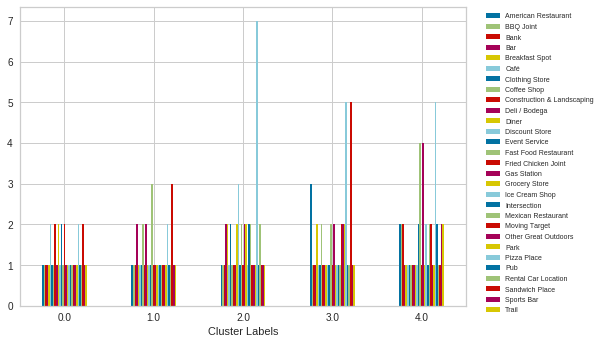

In [40]:
temp = pd.get_dummies(dayton_merged[['1st Most Common Venue']], prefix="", prefix_sep="")
temp['Cluster Labels']= dayton_merged['Cluster Labels']
temp = temp.groupby('Cluster Labels').sum().reset_index()
temp.set_index('Cluster Labels', inplace=True)
temp = temp+1
temp
temp.plot.bar(rot=0).legend(fontsize=7, bbox_to_anchor=(1.3,1))

In [41]:
# ### cluster labels:
# dayton_onehot
# temp = dayton_onehot.groupby('Neighborhood').sum().reset_index()
# temp['Cluster Labels']= dayton_merged['Cluster Labels']
# temp = temp.groupby('Cluster Labels').sum().reset_index()
# temp.set_index('Cluster Labels', inplace=True)
# temp
l=[]
for i in np.arange(5):
    l.append(list(temp.columns[list(temp.iloc[i,:].argsort()[-3:][::-1])]))
pd.DataFrame({'top 3 venues':l},index=np.linspace(0,4,5))

,top 3 venues
0.0,"[Fried Chicken Joint, Event Service, Sandwich ..."
1.0,"[Sandwich Place, Fast Food Restaurant, Pizza P..."
2.0,"[Pizza Place, Discount Store, Mexican Restaurant]"
3.0,"[Sandwich Place, Pizza Place, American Restaur..."
4.0,"[Pizza Place, Fast Food Restaurant, Gas Station]"


In [42]:
temp = dayton_merged
temp['Income'] = temp[['Income']].astype(int)
temp['population'] = temp[['population']].astype(int)
temp['Male_above_18'] = temp[['Male_above_18']].astype(int)
temp['Female_above_18'] = temp[['Female_above_18']].astype(int)
temp['PropertyCost'] = temp[['PropertyCost']].astype(int)
temp = temp.groupby('Cluster Labels').mean().reset_index()
temp.set_index('Cluster Labels', inplace=True)
temp

,level_0,index,latitude,longitude,population,Male_above_18,Female_above_18,Income,PropertyCost,Brewery
Cluster Labels,,,,,,,,,,
0.0,38.857143,38.857143,39.887771,-84.214229,14377.000000,4999.428571,5868.285714,25566.000000,119757.142857,0.001429
1.0,46.750000,46.750000,39.836550,-84.122938,17874.125000,6784.000000,7333.250000,25022.125000,107725.000000,0.013186
2.0,38.555556,38.555556,39.788233,-84.180872,15765.833333,5757.555556,6425.277778,30336.111111,127150.000000,0.005811
3.0,32.588235,32.588235,39.864500,-84.052288,11296.000000,4243.823529,4599.941176,28317.882353,132917.647059,0.005742
4.0,28.100000,28.100000,39.827940,-84.024500,10938.100000,4143.350000,4424.450000,28762.650000,131860.000000,0.004361


### Cluster 2 is chosen beacuse it has highest per capita income and among the highest pouplation neighborhoods

In [48]:
# for example
dayton_merged[dayton_merged['Income'].astype(int) == dayton_merged['Income'].astype(int).max()]

,Cluster Labels,postal_code,place_name,county_name,latitude,longitude,population,Male_above_18,Female_above_18,Income,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
52,2.0,45419,Dayton,Montgomery,39.7155,-84.1637,15097,5269,6011,46363,...,Pizza Place,Bar,Park,Coffee Shop,Grocery Store,Bakery,Ice Cream Shop,Sandwich Place,Chinese Restaurant,Steakhouse


In [35]:
# Dayton_venues['Venue Category'].unique()

## Discussion <a name="discussion"></a>

### Sub-select cities within cluster 3 and without existing breweries

In [50]:
temp =  dayton_merged
temp['Brewery'] = dayton_grouped['Brewery']
temp = temp[dayton_merged['Cluster Labels']==2]
temp = temp[temp['Brewery']==0]
temp
# 'Brewery'

,Cluster Labels,postal_code,place_name,county_name,latitude,longitude,population,Male_above_18,Female_above_18,Income,...,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Brewery
15,2.0,45325,Farmersville,Montgomery,39.6867,-84.4205,2266,832,999,31675,...,Pizza Place,Park,ATM,Football Stadium,Food Truck,Food Stand,Food & Drink Shop,Food,Eye Doctor,0.0
17,2.0,45327,Germantown,Montgomery,39.6244,-84.3764,9356,3355,3604,30026,...,Grocery Store,Discount Store,American Restaurant,Diner,Mexican Restaurant,Café,Fast Food Restaurant,Gas Station,Chinese Restaurant,0.0
22,2.0,45342,Miamisburg,Montgomery,39.6321,-84.2675,36659,13634,14722,33143,...,Fast Food Restaurant,Sandwich Place,Discount Store,Pharmacy,Gas Station,BBQ Joint,Food Truck,Ice Cream Shop,Golf Course,0.0
23,2.0,45344,New Carlisle,Clark,39.9300,-84.0217,16104,5802,6149,26279,...,Pharmacy,Intersection,Sandwich Place,Coffee Shop,Bank,Bakery,Restaurant,Flower Shop,Fried Chicken Joint,0.0
24,2.0,45345,New Lebanon,Montgomery,39.7398,-84.3956,6458,2217,2613,24014,...,Grocery Store,Fast Food Restaurant,Diner,Hunting Supply,Pharmacy,Video Store,Gas Station,Sandwich Place,Fabric Shop,0.0
34,2.0,45372,Tremont City,Clark,40.0139,-83.8333,319,122,132,25755,...,Airport,Electronics Store,Women's Store,Flower Shop,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flea Market,0.0
36,2.0,45377,Vandalia,Montgomery,39.8883,-84.2023,15280,5933,6386,33001,...,Fast Food Restaurant,Pizza Place,Sandwich Place,Bank,Discount Store,Gas Station,Park,Chinese Restaurant,Mexican Restaurant,0.0
37,2.0,45383,West Milton,Miami,39.9531,-84.3242,6912,2709,2853,26005,...,ATM,Grocery Store,Discount Store,Bank,American Restaurant,Video Store,Bar,Sandwich Place,Fish & Chips Shop,0.0
44,2.0,45405,Dayton,Montgomery,39.7899,-84.2135,16845,6067,7166,20185,...,Fast Food Restaurant,Pharmacy,Sandwich Place,Bank,Discount Store,Gas Station,Park,Gym / Fitness Center,Bar,0.0
47,2.0,45410,Dayton,Montgomery,39.7474,-84.1600,16079,6327,6174,20368,...,Pizza Place,Sandwich Place,Brewery,Coffee Shop,American Restaurant,Record Shop,Mexican Restaurant,Gay Bar,Theater,0.0


In [53]:
# create map
Final_selection = temp
map_clusters = folium.Map(location=[Final_selection['latitude'].mean(), Final_selection['longitude'].mean()], zoom_start=12)
#tiles='Stamen Toner',
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Final_selection['latitude'], Final_selection['longitude'], Final_selection['place_name'], Final_selection['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

From the results discovered and presented, the following observations and recommendations can be made:
* Based on the criteria given by the investor group and the cluster data, the main neighborhood recommendation would be for those in cluster 2. This cluster was selected bacuse of high income and genrally high population levels as compared to other clusters.
* Additionally, from the subselection, it becomes clear that neighborhoods are close to the main population centers in the counties.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify neighborhoods in Ohio close to Dayton, with a large number of drinking age people who can afford good beer from a local brewery, in order to aid stakeholders in narrowing down the search for optimal location for a new Brewery. 

By determining the poupaltion and demographics, including an estimate of spending power on the basis of income and housing price, we have identified 12 neighborhoods from all found in the 4 surrounding counties (~90 neighborhoods). 

The aid the stakeholders with getting an additional sense of the type of neighborhoods we have included the 10 most common venues in the neighborhoods. The house price can be used as a surrogate to estimate real estate costs in the neighborhoods. 

Final decission on optimal brewery location will be made by stakeholders based on specific characteristics of neighborhoods and locations among the 12 shortlisted, taking into consideration additional factors like attractiveness of each location (proximity to park or water), accessability, real estate availability, prices etc.